In [1]:
#=
# Package installation
using Pkg
Pkg.add("DataFrames")
Pkg.add("StatsBase")
Pkg.add("NeutralLandscapes")
Pkg.add("PkgCite")
Pkg.add("Plots")
Pkg.add("PGFPlotsX")
Pkg.add("Distributions")
=#

In [105]:
using DataFrames
using StatsBase
using Distributions
using Random
using NeutralLandscapes # There's an incompatability compiling this with another package, but the ones here aren't it
using PkgCite
using Plots; pgfplotsx()

Plots.PGFPlotsXBackend()

In [106]:
land_size = 25
n_land_classes = 5

# Create 10x10 neutral binary landscape
clustered_land = rand(NearestNeighborCluster(0.2), (land_size, land_size))
landscape = classify(clustered_land, ones(n_land_classes)) .- 1

#heatmap(landscape)


25×25 Matrix{Float64}:
 2.0  2.0  0.0  4.0  1.0  3.0  3.0  0.0  …  3.0  0.0  0.0  0.0  0.0  0.0  0.0
 2.0  2.0  2.0  4.0  1.0  3.0  3.0  0.0     2.0  2.0  0.0  0.0  0.0  0.0  4.0
 4.0  2.0  0.0  4.0  4.0  0.0  0.0  0.0     4.0  4.0  0.0  0.0  0.0  4.0  4.0
 4.0  0.0  0.0  4.0  4.0  0.0  0.0  0.0     4.0  4.0  3.0  3.0  3.0  4.0  4.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  3.0     3.0  3.0  3.0  3.0  3.0  4.0  4.0
 1.0  1.0  0.0  3.0  3.0  3.0  3.0  3.0  …  3.0  3.0  3.0  3.0  4.0  4.0  4.0
 1.0  1.0  0.0  3.0  3.0  3.0  3.0  3.0     1.0  1.0  1.0  1.0  4.0  3.0  3.0
 4.0  4.0  4.0  4.0  4.0  4.0  0.0  3.0     1.0  1.0  1.0  1.0  3.0  3.0  3.0
 4.0  4.0  4.0  4.0  4.0  0.0  0.0  3.0     1.0  0.0  1.0  2.0  2.0  3.0  1.0
 4.0  4.0  4.0  4.0  2.0  0.0  4.0  3.0     0.0  0.0  0.0  2.0  2.0  1.0  1.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  1.0  1.0  3.0  4.0  4.0     2.0  3.0  3.0  3.0  3.0  2.0  2.0
 0.0  0.0  0.0  0.0  3.0  3.0  3.0  3.0     

In [205]:
# Create data frame of lil guys to run around it
n_guys=25
lil_guys = DataFrame(id = string.(collect(1:n_guys)), x = rand(1:land_size,n_guys), y = rand(1:land_size,n_guys),
                    disease = 0, time_since_inf = 0, sex = Int.(rand(Bernoulli(0.5), n_guys)), mom = NaN,
                    vaccinated = 0, age = 52)

# Initialize disease
lil_guys.disease[rand(1:n_guys,3)] .= 1


Row,id,x,y,disease,time_since_inf,sex,mom,vaccinated,age
,String,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64
1,1,17,7,0,0,0,NaN,0,52
2,2,8,10,1,0,1,NaN,0,52
3,3,22,23,0,0,1,NaN,0,52
4,4,23,9,0,0,0,NaN,0,52
5,5,19,5,0,0,0,NaN,0,52
6,6,16,12,0,0,1,NaN,0,52
7,7,12,23,0,0,1,NaN,0,52
8,8,15,12,0,0,0,NaN,0,52
9,9,4,9,0,0,1,NaN,0,52


In [206]:
# Create function for the guys to look at their surroundings
function look_around(x,y)
    # Get vector of all possible moves
    all_moves = [(x-1, y+1), (x, y+1), (x+1, y+1),
                (x-1, y), (x+1, y),
                (x-1, y-1), (x, y-1), (x+1, y-1)]

    # Get indices of impossible moves
    good_moves = findall([(0 .< x[1] .< land_size) .&& (0 .< x[2] .< land_size) for x in all_moves])

    # Remove impossible moves
    poss_moves = copy(all_moves[good_moves])

end

look_around (generic function with 1 method)

In [207]:
# Movement and disease function
function move(coords, dat)
    # Create blank array
    habs = Vector(undef, length(coords))

    # Get habitat type to create weights
    for i in 1:length(coords)
        habs[i] = landscape[CartesianIndex.([x[1] for x in coords[i]], [x[2] for x in coords[i]])]
    end
    
    # Choose new location
    new_location = sample.(coords, Weights.(habs))

    # Make it a df
    new_spots = DataFrame(x = [x[1] for x in new_location], y = [x[2] for x in new_location])

    # Change juvenile coords so they follow mom
    kids = findall(lil_guys.age .< 52)

    x_coords = vcat([lil_guys.x[lil_guys.id .== lil_guys.mom[kids][i]] for i in 1:length(kids)]...)
    y_coords = vcat([lil_guys.y[lil_guys.id .== lil_guys.mom[kids][i]] for i in 1:length(kids)]...)

    lil_guys.x[kids] = x_coords
    lil_guys.y[kids] = y_coords
 
    # Update data frame
    dat.x = new_spots.x
    dat.y = new_spots.y

    # Update time since infection
    dat.time_since_inf[dat.disease.==1] = dat.time_since_inf[dat.disease.==1] .+ 1
    
    # Disease transmission
    if length(filter(kv -> kv.second > 1, countmap(new_location))) > 0
        # get coordinates where there are multiple guys
        many_guys = collect(keys(filter(kv -> kv.second > 1, countmap(new_location))))
        indices = [findall(==(x), new_location) for x in many_guys]

        # spread disease
        diseases = dat[:,4]

        for i in 1:length(indices)
            # drop vaccinated guys
            if length(findall(x->x==1, dat.vaccinated[indices[i]])) > 0 & length(indices[i]) > 0
                filter!(x->!(x in findall(x->x==1, dat.vaccinated)), indices[i])
            end

            # spread disease to unvaccinated guys
            diseases[indices[i]] .= maximum(diseases[indices[i]])
        end
        
        dat.disease = diseases
    end
    
end

move (generic function with 1 method)

In [208]:
# Mortality function
function dont_fear_the_reaper(dat, time)
    # random mortality
    rand_deaths = rand(Bernoulli(0.005),size(lil_guys,1))
    deleteat!(lil_guys, findall(rand_deaths==1))

    # disease mortality
    filter!(:time_since_inf => <=(time), dat)

    # old age mortality
    if length(findall(x-> x>=(52*6), dat.age)) > 0
        filter!(:age => <=(52*6), dat)
    end

    # orphan mortality
    kids = findall(dat.age .< 52)

    no_mom = findall(x -> !(x in dat.id), dat.mom[kids])

    filter!(:mom => !in(dat.mom[kids][no_mom]), dat)

end

dont_fear_the_reaper (generic function with 1 method)

In [209]:
# Reproduction function
function reproduce(dat)
    # Get females only
    females = filter(:sex => ==(1), dat)
    
    # Choose females that actually reproduce
    reproducing = females[randsubseq(1:size(females,1), 0.25),:]

    # Assign number of offspring to each reproducing female
    noffspring = rand(Poisson(2), size(reproducing,1))

    # Create offspring at location of mother
    devil_spawn = DataFrame(x = Int[], y = Int[], mom = String[])
    for i in 1:length(noffspring)
        for j in 1:noffspring[i]
            push!(devil_spawn, (reproducing.x[i], reproducing.y[i], reproducing.id[i]))
        end
    end

    # Fill in missing cols
    devil_spawn.disease .= 0
    devil_spawn.time_since_inf .= 0
    devil_spawn.sex .= Int.(rand(Bernoulli(0.5), size(devil_spawn,1)))
    devil_spawn.vaccinated .= 0
    devil_spawn.age .= 0

    id_vector = collect((maximum(parse.(Int64,dat.id))+1):(maximum(parse.(Int64,dat.id))+size(devil_spawn,1)))
    devil_spawn.id = string.(id_vector)

    # Append to main dataset
    append!(dat, devil_spawn, promote = true)
    
end

reproduce (generic function with 1 method)

In [222]:
# Vaccination function
function ORV(dat, land=nothing)
    if land==nothing 
        # Create array of vaccination probabilities
        land = rand(NearestNeighborCluster(0.2), (land_size, land_size))
    end

    # Get probs of vaccination at guys' locations
    vaxprob = land[CartesianIndex.(dat.x, dat.y)]

    # Juveniles have lower probs
    kids = findall(dat.age .< 52)
    vaxprob[kids] = vaxprob[kids]./2

    # Generate vaccine outcomes
    vax = Int.(rand.(Bernoulli.(vaxprob)))

    # Update data
    dat.vaccinated = vax

    dat
end

ORV (generic function with 2 methods)

In [223]:
#Just the model results
time_steps = 50

for step in 1:time_steps

    lil_guys.age = lil_guys.age .+ 1

    moves = look_around.(lil_guys.x, lil_guys.y)
    move(moves, lil_guys)
    dont_fear_the_reaper(lil_guys, 25)

    if step % 20 == 0
        reproduce(lil_guys)
    end

    
    if step % 25 == 0
        ORV(lil_guys)
    end 
    
end
lil_guys

Row,id,x,y,disease,time_since_inf,sex,mom,vaccinated,age
,String,Int64,Int64,Int64,Int64,Int64,Any,Int64,Int64
1,1,13,13,0,0,0,NaN,1,202
2,3,22,18,0,0,1,NaN,1,202
3,4,14,19,0,0,0,NaN,1,202
4,6,21,1,0,0,1,NaN,0,202
5,7,8,9,0,0,1,NaN,0,202
6,8,6,8,0,0,0,NaN,0,202
7,9,15,7,0,0,1,NaN,1,202
8,11,10,8,0,0,1,NaN,0,202
9,12,14,17,0,0,0,NaN,0,202




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation




MiKTeX requires Windows 10 (or greater): https://miktex.org/announcement/legacy-windows-deprecation


┌ Info: Saved animation to C:\Users\beasl\AppData\Local\Temp\jl_HeDk5i1eF8.gif
└ @ Plots C:\Users\beasl\.julia\packages\Plots\sxUvK\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\beasl\\AppData\\Local\\Temp\\jl_HeDk5i1eF8.gif")
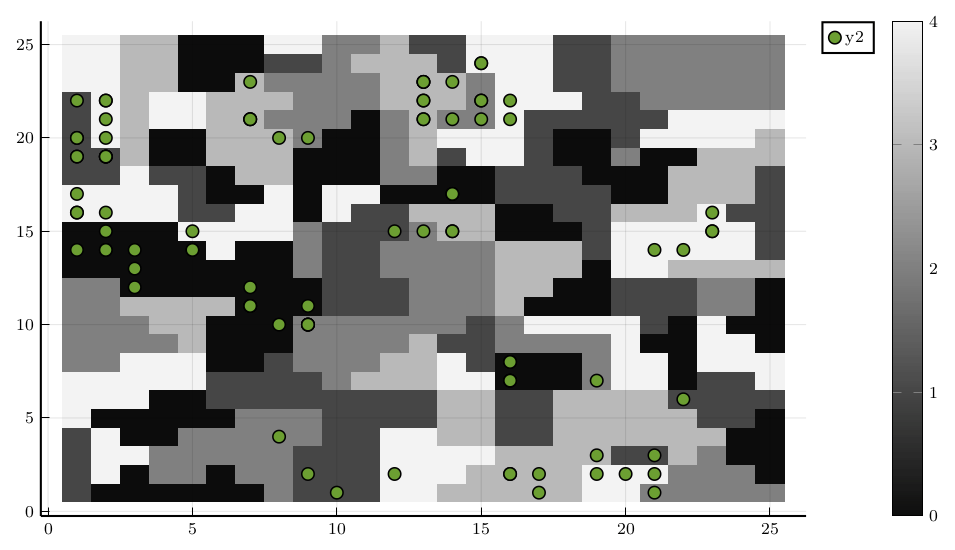

In [75]:

#gif
time_steps = 10

anim = @animate for step in 1:time_steps

    moves = look_around.(lil_guys.x, lil_guys.y)
    move(moves, lil_guys)

    fig = Plots.heatmap(landscape, c = :grays)
    Plots.plot!(lil_guys.x, lil_guys.y, seriestype = :scatter, color = lil_guys.disease)

end

gif(anim, fps = 4)
